# Rojové algoritmy

Na dnešním cvičení se podíváme na další druhy přírodou inspirovaných algoritmů, které se používají pro optimalizační úlohy. Konkrétně to bude algoritmus na optimalizaci pomocí hejna částic a optimalizaci mravenčí kolonií. Oba algoritmy jsou relativně jednoduché na implementaci, a proto je napíšeme sami.

## Optimalizace hejnem částic

Optimalizace hejnem částic je optimalizační algoritmus inspirovaný chováním hejn ryb nebo ptáků při hledání potravy, který se používá pro spojitou optimalizaci. Jedinec, typicky vektor R čísel, se nazývá částice a pohybuje se v hejnu prostorem parametrů. Každá částice je reprezentovaná pomocí 2 vektorů, které určují její pozici a rychlost. Navíc si pamatuje pozici v prostoru, kde měla nejlepší fitness a celé hejno si pamatuje pozici, kde měla nějaká částice nejlepší globální fitness. 

Algoritmus je pak velice jednoduchý -- každá částice se pohybuje v prostoru a je přitahovaná k místu se svým nejlepším řešením a k místu globálního nejlepšího řešení. Na začátku se inicializuje každé částici pozice a rychlost náhodně. Pak se pro každou částici spočítá její fitness, updatuje se dosavadní nejlepší pozice jedince a globální nejlepší pozice v hejnu. Nakonec se spočítá nová rychlost a pozice jedince z původní pozice a rychlosti, jejího nejlepšího místa a globálního nejlepšího místa v hejnu. Toto se opakuje dokud není splněno nějaké ukončovací kritérium, například počet iterací.


Zkusíme se tedy podívat na algoritmus optimalizace hejnem částic (v angličtině particle swarm optimalization (PSO)). Implementace je snadná, protože de facto stačí jenom opsat rovnice.

In [1]:
from collections import namedtuple
import math
import functools
import numpy as np
import csv
import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import collections as mc

Začneme tím, že si definujeme třídu pro částici, která je definovaná svou pozicí a rychlostí. Zároveň si pamatuje svou nejlepší pozici v historii. Zároveň definujeme i metodu, aby se jedinec uměl sám vypsat.

In [2]:
class Particle:
    def __init__(self, position, speed):
        self.position = position
        self.speed = speed
        self.best_position = position
            
    def __print__(self):
        return str(self.position) + ', ' + str(self.speed) + ', ' + str(self.best_position)

Na začátku algoritmu budeme potřebovat umět nainicializovat hejno. To uděláme tak, že každé částici zvolíme náhodnou počáteční pozici a rychlost. Rychlosti se typicky nastavují menší. 

In [3]:
def init_swarm(size, dimension):
    swarm = []
    for _ in range(size):
        swarm.append(Particle(position = np.random.uniform(size=(1,dimension)), 
                              speed = 0.2*np.random.uniform(size=(1,dimension)) - 0.1))
    return swarm

Dále budeme potřebovat funkci na aktualizaci pozic a rychlostí všech částic v hejnu podle rovnic.

In [4]:
def update_swarm(swarm, fit, best_global, phi1=1, phi2=0.5, omega=0.95):
    for particle in swarm:
        particle.speed = omega*particle.speed + phi1*(particle.best_position - particle.position) + phi2*(best_global - particle.position)
        particle.position = particle.position + particle.speed
        
        if fit(particle.position) < fit(particle.best_position):
            particle.best_position=particle.position
    return swarm

Také bude potřeba funkce na update nejlepšího globálního řešení. K tomu si definujeme fitness funkci, která bude jen hodnota rastrigin funkce v daném bodě.

In [5]:
def compute_best_global_position(swarm, fit):
    return min(swarm, key=lambda x: fit(x.best_position)).best_position

# fitness funkce
def fitness(position):
    position = position[0]
    N = len(position)
    A = 10
    value = A*N
    for i in range(0,len(position)):
        value += position[i]**2 - A*math.cos(2*math.pi*position[i])
    return value, 

Nyní už máme všechny funkce, takže si už můžeme definovat hlavní kód algoritmu optimalizace hejnem částic.

In [6]:
def pso(fitness, swarm_size, problem_dim, max_iters):
    swarm = init_swarm(size=swarm_size, dimension=problem_dim)
    best_global_position = compute_best_global_position(swarm, fitness)
    best_fitness = []
    for iteration in range(max_iters):
        swarm = update_swarm(swarm, fitness, best_global_position)
        best_global_position = compute_best_global_position(swarm, fitness)
        print(f'{iteration:4}: {fitness(best_global_position)[0]:.4f}')
        best_fitness.append(fitness(best_global_position)[0])
    return best_global_position, best_fitness

Když máme napsaný celý algoritmus, můžeme ho zkusit otestovat například na problému [Rastrigin funkce](https://en.wikipedia.org/wiki/Rastrigin_function), který jsme řešili na cvičení s evolučními algoritmy. O této funkci jsme si říkali, že je typickým příkladem nelineární funkce a běžně se používá při testování chování optimalizačních algoritmů. Navíc nalezení jejího minima je složité, protože obsahuje spoustu lokálních minim. Minimum funkce je v bodě 0 s hodnotou 0.

   0: 2.3579
   1: 1.6636
   2: 1.2311
   3: 1.1749
   4: 1.1749
   5: 1.1749
   6: 1.1749
   7: 1.1749
   8: 1.0494
   9: 1.0494
  10: 1.0006
  11: 1.0006
  12: 1.0006
  13: 1.0006
  14: 1.0006
  15: 0.9967
  16: 0.9954
  17: 0.9954
  18: 0.9954
  19: 0.9954
  20: 0.9954
  21: 0.9954
  22: 0.9954
  23: 0.9953
  24: 0.9952
  25: 0.9951
  26: 0.9951
  27: 0.9950
  28: 0.9950
  29: 0.9950
best position
[[ 9.66919888e-05  9.94766510e-01 -2.24821532e-04  6.70260740e-05]]


Text(0.5, 0, 'Generace')

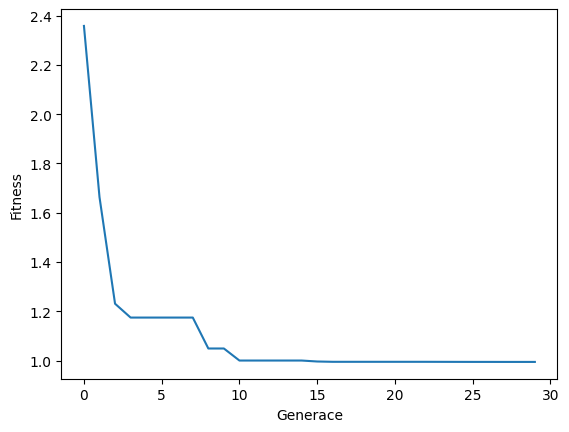

In [7]:
best_position, best_fitness = pso(fitness, swarm_size=1000, problem_dim=4, max_iters=30)
print('best position')
print(best_position)

plt.plot(best_fitness)
plt.ylabel('Fitness')
plt.xlabel('Generace')

Zde si můžeme zkusit měnit dimenzi problému a pozorovat, že pro rostoucí dimenzi je třeba zvětšovat velikost hejna, aby se algoritmus nezasekl v lokálním optimu a že na počtu generací to až zas tolik nezáleží, protože algoritmus brzy zkonverguje do nějakého optima a tam už zůstane.

## Optimalizace mravenčí kolonií

Optimalizace mravenčí kolonií (Ant Colony Optimization (ACO)) je algoritmus inspirovaný chováním mravenců při hledání potravy, který se hodí především pro kombinatorickou optimalizaci, konkrétně na problémy, které se dají převést na problém hledání cest v grafu. 

Mravenci se pohybují v prostředí a zanechávají za sebou feromonouvou stopu, která časem slábne a díky které spolu komunikují a slouží jim jako pozitivní druh zpětné vazby. Mravenec začne v náhodném bodě a rozhoduje se kam půjde dál. Nejprve se pohybují náhodně kolem mraveniště. Jakmile naleznou potravu, vrací se stejnou cestou, kterou k potravě došli a zanechávají za sebou feromonovou stopu. Jakmile nějkaý další mravenec narazí na feromonovou stopu, s větší pravděpodobností se po ní vydá spíše, než aby dále prozkoumával prostředí. Čím více mravenců se pohybuje mezi zdrojem potravy a mraveništěm, tím silnější je stopa a šance, že cesta přitáhne další mravence. Navíc na kratší cestě feromon vyprchává pomaleji, takže bude silnější a bude přitahovat více mravenců.

Jen tak pro zajímavost rozhraní pro modelování různých přírodou inspirovaných systémů a algoritmů [NetLogo](http://ccl.northwestern.edu/netlogo/) poskytuje i simulaci mravenečků při hledání potravy. Podívat se na ně můžeme [zde](http://www.netlogoweb.org/launch#http://www.netlogoweb.org/assets/modelslib/Sample%20Models/Biology/Ants.nlogo).

Zkusíme si s jeho pomocí vyřešit [Problém obchodního cestujícího](https://en.wikipedia.org/wiki/Travelling_salesman_problem), který se dá převést na problém hledání nejkratší Hamiltonovské kružnice v úplném grafu. Hamiltonovská kružnice v grafu je kružnice, která prochází všemi vrcholy. Implementace už je zde trochu složitější, ale pořád celkem rozumná.

Nejprve si vytvoříme kolekci ```namedtuple```, do které si uložíme informace o vrcholu, tedy jeho souřadnice a název. Je vhodnější než normální třída, protože je to rychlejší struktura. 

In [8]:
Vertex = namedtuple('Vertex', ['name', 'x', 'y'])

Dále budeme potřebovat funkci, co nám spočítá vzdálenost dvou bodů. To uděláme chytře a použijeme k tomu lru (least recently used) cache, která si pamatuje si vyhodnocené funkce a při jejich opakovaném volání se stejnými parametry se nemusí znovu vyhodnocovat.

In [9]:
@functools.lru_cache(maxsize=None)
def distance(v1, v2):
    return math.sqrt((v1.x - v2.x)**2+(v1.y - v2.y)**2)

Dále se bude hodit fitness funkce, která jen vyhodnotí danou cestu mezi městy tak, ze bere dvojice po sobě jdoucích vrcholů v řešení a sčítá vzdálenosti měst.

In [10]:
def fitness(vertices, distance, solution):
    solution_distance = 0
    for x, y in zip(solution, solution[1:]):
        solution_distance += distance(vertices[x], vertices[y])
    solution_distance += distance(vertices[solution[-1]], vertices[solution[0]])
    return solution_distance

Samotný algoritmus bude ještě potřebovat funkci na počáteční inicializaci feromonu, která by sice měla být stopa všude nulová, ale protože s ní pracujeme jako s pravděpodobností, tak by to nefungovalo, tak ji nastavíme na nějakou malou hodnotu. Také bude potřeba dělat update feromonu a to tak, že na všechny hrany v cestě rozpočítáme rovnoměrně tu fitness, která říká, jak byla váha dobrá. A protože délku chceme minimalizovat, takže použijeme inverzní Q/fit, kde Q bude nějaká konstanta.

In [11]:
def initialize_pheromone(N):
    return 0.01*np.ones(shape=(N,N))

def update_pheromone(pheromones_array, solutions, fits, Q=100, rho=0.6):
    pheromone_update = np.zeros(shape=pheromones_array.shape)
    for solution, fit in zip(solutions, fits):
        for x, y in zip(solution, solution[1:]):
            pheromone_update[x][y] += Q/fit
        pheromone_update[solution[-1]][solution[0]] += Q/fit
    
    return (1-rho)*pheromones_array + pheromone_update

Ještě nám zbývá pomocná funkce, kde mravenec generuje řešení, tedy náhodně prochází města, dokud neobejde všechny. Pak už můžeme napsat hlavní funkci algoritmu, kde se vytváří řešení, a podle jejich kvality se upravuje feromon na hranách. Zároveň si pamatujeme nejlepší řešení, abychom ho na konci mohli vrátit.

In [12]:
def generate_solutions(vertices, pheromones, distance, N, alpha=1, beta=3):
    
    # pravdepodobnost vyberu dalsiho mesta
    def compute_prob(v1, v2):
        dist = 1/distance(vertices[v1], vertices[v2])
        tau = pheromones[v1, v2]
        ret = pow(tau, alpha) * pow(dist,beta)
        return ret if ret > 0.000001 else 0.000001

    pheromones_shape = pheromones.shape[0]
    for i in range(N):
        available = list(range(pheromones_shape))
        solution = [np.random.randint(0, pheromones_shape)]
        available.remove(solution[0])
        while available:
            probs = np.array(list(map(lambda x: compute_prob(solution[-1], x), available)))
            selected = np.random.choice(available, p=probs/sum(probs)) # vyber hrany
            solution.append(selected)
            available.remove(selected)
        yield solution


Nyní už si můžeme vytvořit hlavní kód ACO.

In [13]:
def ant_solver(vertices, distance, ants=10, max_iterations=3000, alpha=1, beta=3, Q=100, rho=0.8):
    pheromones = initialize_pheromone(len(vertices))
    best_solution = None
    best_fitness = float('inf')
    
    for i in range(max_iterations):
        solutions = list(generate_solutions(vertices, pheromones, distance, ants, alpha=alpha, beta=beta))
        fits = list(map(lambda x: fitness(vertices, distance, x), solutions))
        pheromones = update_pheromone(pheromones, solutions, fits, Q=Q, rho=rho)
        
        for s, f in zip(solutions, fits):
            if f < best_fitness:
                best_fitness = f
                best_solution = s
        
        print(f'{i:4}, {np.min(fits):.4f}, {np.mean(fits):.4f}, {np.max(fits):.4f}')
    return best_solution, pheromones

Zkusíme si nyní algoritmus otestovat na hlavních evropských městech, vstupní data jsou uložena v souboru *cities.csv*.

In [14]:
vertices = []
with open('cities.csv') as cities_file:
    csv_reader = csv.reader(cities_file, delimiter=',')
    for row in csv_reader:
        vertices.append(Vertex(row[0], float(row[2]), float(row[1])))

pprint.pprint(vertices)

best_solution, pheromones = ant_solver(vertices, distance)

[Vertex(name='Tirana', x=19.81666667, y=41.31666667),
 Vertex(name='Andorra la Vella', x=1.5, y=42.5),
 Vertex(name='Vienna', x=16.36666667, y=48.21666667),
 Vertex(name='Minsk', x=27.55, y=53.9),
 Vertex(name='Brussels', x=4.316666667, y=50.81666667),
 Vertex(name='Sarajevo', x=18.36666667, y=43.85),
 Vertex(name='Sofia', x=23.3, y=42.68333333),
 Vertex(name='Zagreb', x=15.96666667, y=45.8),
 Vertex(name='Nicosia', x=33.36666667, y=35.15),
 Vertex(name='Prague', x=14.41666667, y=50.06666667),
 Vertex(name='Copenhagen', x=12.56666667, y=55.66666667),
 Vertex(name='Tallinn', x=24.73333333, y=59.43333333),
 Vertex(name='Helsinki', x=24.93333333, y=60.16666667),
 Vertex(name='Paris', x=2.333333333, y=48.85),
 Vertex(name='Berlin', x=13.36666667, y=52.51666667),
 Vertex(name='Athens', x=23.71666667, y=37.96666667),
 Vertex(name='Budapest', x=19.06666667, y=47.5),
 Vertex(name='Reykjavik', x=-21.91666667, y=64.13333333),
 Vertex(name='Dublin', x=-6.25, y=53.31666667),
 Vertex(name='Rome', x

 170, 246.0367, 271.9806, 302.9705
 171, 260.1412, 279.6883, 327.1484
 172, 257.4923, 274.1212, 288.8438
 173, 255.9086, 275.9888, 310.7860
 174, 246.1885, 273.5016, 301.2512
 175, 257.4688, 274.4027, 317.4900
 176, 250.0756, 270.9094, 324.5897
 177, 246.9389, 272.3608, 318.7188
 178, 251.2775, 262.5869, 277.0380
 179, 251.2275, 272.7534, 322.2024
 180, 251.2275, 272.6609, 296.2440
 181, 251.2775, 276.7592, 302.5370
 182, 260.3094, 282.3390, 310.9249
 183, 255.1366, 280.2149, 337.5951
 184, 248.6161, 291.8483, 348.0415
 185, 253.6064, 274.0096, 331.3563
 186, 252.0759, 279.6912, 306.2906
 187, 251.2275, 295.3797, 367.5485
 188, 267.8907, 293.4723, 335.8513
 189, 256.7804, 272.8737, 316.8662
 190, 248.3249, 269.1326, 312.5042
 191, 247.7938, 272.7638, 301.8772
 192, 251.9207, 282.8621, 320.5399
 193, 248.3249, 271.9976, 341.6885
 194, 251.2775, 271.4298, 329.6883
 195, 249.6520, 281.0026, 332.3472
 196, 245.4362, 266.7959, 288.3434
 197, 251.2775, 268.8536, 309.3028
 198, 246.6543, 270.

 406, 264.3079, 292.5892, 339.1981
 407, 269.2553, 304.8919, 334.8765
 408, 260.0287, 292.6244, 328.3926
 409, 274.2600, 297.4946, 316.7389
 410, 263.0119, 304.6854, 330.1575
 411, 252.1361, 296.0477, 332.4128
 412, 254.2318, 295.8221, 345.6408
 413, 251.9199, 296.7409, 322.5480
 414, 262.0924, 295.9184, 336.4291
 415, 263.0565, 300.6287, 342.5749
 416, 273.2819, 304.9092, 321.0430
 417, 261.5654, 295.7140, 320.1933
 418, 259.8684, 295.3078, 319.8624
 419, 264.4859, 294.5434, 324.4833
 420, 261.5654, 282.1864, 322.5626
 421, 253.3817, 288.9927, 334.7243
 422, 254.9667, 273.9243, 291.9624
 423, 264.5188, 290.7470, 323.1228
 424, 260.6299, 292.7918, 314.4871
 425, 250.3468, 289.4968, 316.0096
 426, 252.6998, 285.6979, 326.3915
 427, 250.0140, 284.1113, 312.7189
 428, 250.3468, 279.6568, 304.4094
 429, 254.9667, 277.8611, 301.3632
 430, 250.3468, 286.8285, 326.1742
 431, 250.3468, 283.6659, 338.6321
 432, 273.9174, 304.7067, 322.3816
 433, 254.4259, 293.8048, 321.5686
 434, 263.9501, 289.

 644, 267.6522, 287.1932, 300.7896
 645, 292.6952, 315.3445, 344.9930
 646, 273.5302, 305.6547, 329.2549
 647, 286.8104, 305.7816, 343.2998
 648, 284.2253, 310.7517, 330.6440
 649, 294.1567, 316.0661, 341.8023
 650, 272.5132, 312.3183, 335.1983
 651, 272.2593, 303.3209, 330.7957
 652, 279.8450, 311.2256, 349.1842
 653, 288.5933, 308.8693, 350.9024
 654, 266.6170, 302.4159, 352.2698
 655, 286.5185, 308.7601, 351.1361
 656, 289.2319, 308.3151, 340.6525
 657, 281.2503, 307.7858, 345.7431
 658, 272.5478, 300.5740, 329.2308
 659, 266.8868, 296.4992, 332.3663
 660, 267.3453, 289.3618, 334.6204
 661, 269.1578, 293.5915, 332.5979
 662, 276.5190, 295.8320, 340.7757
 663, 280.3028, 307.7075, 336.7175
 664, 280.3028, 305.7336, 339.5557
 665, 284.8148, 307.8206, 335.8684
 666, 276.4596, 304.7853, 348.7858
 667, 261.6095, 313.7195, 376.6645
 668, 273.7450, 296.5288, 330.7461
 669, 261.8250, 284.8000, 308.7071
 670, 267.9731, 309.3843, 344.8890
 671, 275.9748, 300.8048, 324.1650
 672, 262.9832, 287.

 885, 238.5675, 263.8754, 288.1508
 886, 235.5668, 256.8201, 287.4419
 887, 231.3575, 262.4173, 304.5652
 888, 244.7550, 275.1180, 323.3712
 889, 257.4441, 281.3770, 316.7877
 890, 242.2312, 257.3959, 298.2310
 891, 242.1155, 286.3970, 350.6406
 892, 242.2312, 287.9753, 334.0533
 893, 246.8256, 269.2089, 314.0230
 894, 247.2620, 291.9100, 362.0775
 895, 238.3702, 271.8027, 293.3459
 896, 238.3702, 271.0813, 290.1229
 897, 238.3702, 279.3150, 318.6962
 898, 241.6353, 267.4517, 306.8247
 899, 244.7550, 265.5316, 280.5872
 900, 233.3839, 267.5355, 307.3847
 901, 244.9406, 275.8007, 358.6605
 902, 233.3839, 273.0879, 311.0555
 903, 260.1734, 287.7384, 340.0920
 904, 244.7550, 271.5380, 297.4141
 905, 240.5031, 274.5244, 299.8748
 906, 244.8540, 273.4501, 314.0535
 907, 244.7550, 271.3773, 291.4976
 908, 234.0831, 266.3585, 296.9882
 909, 247.7030, 269.6742, 299.5960
 910, 251.5234, 271.3976, 295.7779
 911, 249.4405, 269.6133, 305.6336
 912, 238.5675, 272.8487, 312.2792
 913, 238.5675, 269.

1127, 234.3588, 248.5225, 277.7929
1128, 231.9165, 254.0602, 280.8727
1129, 235.2558, 261.3286, 315.3158
1130, 237.4246, 262.2819, 292.1271
1131, 238.0012, 270.9599, 299.6598
1132, 230.8198, 269.8156, 315.9796
1133, 235.2558, 263.5441, 323.1026
1134, 236.0818, 254.4869, 281.0096
1135, 236.2251, 262.4084, 292.9401
1136, 239.6145, 257.1831, 286.1274
1137, 231.6872, 254.2072, 321.1991
1138, 232.4502, 253.9107, 292.7428
1139, 236.1309, 260.5307, 318.6973
1140, 239.9338, 256.0152, 281.1701
1141, 231.6872, 269.3466, 312.0371
1142, 231.6872, 255.3973, 287.0366
1143, 230.8198, 255.9347, 295.1617
1144, 238.9062, 270.2536, 299.8466
1145, 229.0180, 259.8239, 290.5548
1146, 234.8865, 258.9116, 285.4367
1147, 239.4096, 264.9532, 285.9166
1148, 237.4246, 270.9762, 341.5279
1149, 236.0818, 258.1331, 301.6337
1150, 236.2251, 253.2053, 289.9207
1151, 236.7125, 253.0492, 303.1445
1152, 230.8198, 253.9429, 299.5541
1153, 236.8413, 263.4472, 315.6361
1154, 228.6878, 268.1848, 301.9347
1155, 228.6878, 255.

1365, 258.8640, 291.4524, 322.8487
1366, 257.4933, 294.1843, 355.7465
1367, 263.8053, 295.1951, 316.8825
1368, 272.2347, 289.1623, 318.8212
1369, 245.8093, 286.2582, 341.9954
1370, 251.6394, 288.3232, 325.8673
1371, 251.6394, 293.3202, 319.1166
1372, 263.6364, 300.9980, 348.6461
1373, 251.2299, 280.4770, 300.2912
1374, 256.2387, 283.7640, 310.8484
1375, 255.8916, 293.0414, 337.7643
1376, 249.5927, 287.5966, 358.7533
1377, 244.0252, 299.8487, 338.4314
1378, 241.7257, 291.5029, 337.4472
1379, 241.6372, 280.5770, 317.2190
1380, 242.8149, 275.4326, 309.6253
1381, 240.3484, 287.8659, 346.3001
1382, 257.1120, 286.9626, 320.3166
1383, 253.0582, 277.0017, 323.6115
1384, 246.5335, 291.9672, 324.7978
1385, 250.9245, 296.8614, 327.6039
1386, 259.9054, 282.9201, 321.9428
1387, 240.3484, 284.5732, 327.2734
1388, 240.3484, 283.9737, 324.7207
1389, 246.7626, 285.6650, 334.8549
1390, 253.7582, 286.1633, 315.3125
1391, 254.8503, 277.4437, 324.4262
1392, 250.7461, 282.0819, 315.9496
1393, 256.8649, 312.

1601, 282.1774, 302.0798, 378.0640
1602, 281.7205, 291.1512, 331.3145
1603, 276.9599, 296.2311, 334.5759
1604, 278.7867, 301.0582, 333.6943
1605, 284.8412, 302.0300, 334.9515
1606, 276.9599, 288.6142, 312.5354
1607, 286.7666, 310.8579, 352.4103
1608, 277.5143, 291.9665, 338.9318
1609, 276.8937, 297.5228, 338.9318
1610, 244.8147, 287.5675, 317.6937
1611, 270.2445, 300.9188, 361.3861
1612, 277.6756, 301.8987, 316.2818
1613, 276.5307, 288.6140, 296.2886
1614, 284.6823, 304.8198, 326.9609
1615, 286.4125, 302.2123, 322.4132
1616, 281.9612, 295.7983, 325.2075
1617, 285.6914, 303.5388, 332.6648
1618, 277.6756, 292.0345, 311.8293
1619, 277.6756, 294.7185, 317.6272
1620, 277.6756, 290.6252, 312.4242
1621, 277.6756, 290.6864, 304.6924
1622, 277.1359, 294.9336, 313.3046
1623, 277.6756, 307.1552, 379.8545
1624, 277.6756, 294.5041, 317.5024
1625, 276.9599, 291.3020, 315.5698
1626, 288.4946, 297.2567, 308.3156
1627, 269.4444, 285.9250, 312.5988
1628, 276.9599, 288.6714, 312.6221
1629, 269.4444, 292.

1843, 249.8254, 276.1055, 321.2872
1844, 248.2143, 270.4792, 311.2120
1845, 258.3618, 270.6162, 294.3358
1846, 255.1102, 274.7049, 293.8468
1847, 251.6712, 271.5544, 290.4635
1848, 249.6699, 287.8135, 353.5115
1849, 248.3843, 278.3377, 319.0040
1850, 255.1069, 280.2372, 325.4838
1851, 246.4356, 269.9782, 286.5386
1852, 256.2096, 276.4734, 310.8216
1853, 258.4597, 281.6633, 310.9442
1854, 251.3815, 275.8707, 299.8960
1855, 251.3815, 266.6854, 290.7649
1856, 250.2991, 291.6785, 341.6416
1857, 246.0553, 270.1171, 311.4564
1858, 250.2991, 263.6206, 281.0148
1859, 251.5821, 280.7068, 326.6416
1860, 253.4904, 279.1397, 305.6375
1861, 250.4211, 278.8269, 318.7993
1862, 249.9215, 280.5872, 315.7414
1863, 252.3385, 272.3456, 291.2587
1864, 251.5570, 289.0993, 335.6189
1865, 253.9805, 285.0595, 315.3100
1866, 242.2037, 278.9034, 309.3742
1867, 251.5821, 275.3482, 313.6374
1868, 252.3131, 282.1542, 309.3297
1869, 249.8412, 277.9409, 317.9187
1870, 249.8412, 272.5405, 301.0791
1871, 250.1228, 278.

2079, 251.8924, 276.4612, 327.5910
2080, 246.7648, 271.6749, 296.0306
2081, 248.8899, 278.6703, 347.3633
2082, 255.0499, 283.6510, 309.2976
2083, 251.5373, 279.4513, 308.5988
2084, 251.4264, 274.4305, 302.4148
2085, 249.8412, 275.5781, 305.6331
2086, 251.8752, 264.4027, 271.2746
2087, 251.5373, 275.6664, 306.7766
2088, 254.2489, 281.1961, 327.3826
2089, 251.4277, 278.3183, 320.2835
2090, 267.6512, 284.1275, 324.6038
2091, 252.4916, 275.6284, 333.5251
2092, 256.7625, 284.3533, 321.7002
2093, 246.9377, 275.7245, 302.8676
2094, 248.0787, 290.4072, 359.7506
2095, 271.7604, 294.8875, 355.3201
2096, 244.2279, 277.3935, 336.9754
2097, 246.3395, 280.9648, 312.1083
2098, 246.3395, 272.2623, 307.7482
2099, 250.1884, 270.2974, 287.7539
2100, 247.4338, 269.0770, 281.4290
2101, 250.1884, 269.4728, 310.9146
2102, 260.0989, 281.1982, 304.0294
2103, 248.4115, 277.7320, 315.4971
2104, 260.7572, 279.4196, 295.7789
2105, 250.9143, 269.4675, 293.6857
2106, 248.9900, 276.3351, 299.9925
2107, 250.9143, 277.

2316, 250.4919, 272.7812, 321.7234
2317, 248.8237, 272.5517, 320.3680
2318, 246.3395, 277.5452, 315.2103
2319, 250.3326, 276.9106, 330.2923
2320, 247.4144, 281.1497, 348.2928
2321, 246.5044, 273.0742, 336.4540
2322, 248.0787, 272.0083, 300.0309
2323, 252.6635, 270.5709, 293.5424
2324, 246.7133, 268.4202, 291.6853
2325, 249.8854, 277.8476, 322.6290
2326, 249.9448, 275.6003, 321.1500
2327, 249.8754, 276.7994, 311.7338
2328, 249.8754, 270.4978, 314.6081
2329, 256.8321, 285.1309, 328.9070
2330, 249.9267, 282.9679, 309.2287
2331, 250.1645, 281.8617, 329.9478
2332, 248.1421, 279.0816, 315.8002
2333, 256.9223, 286.6847, 360.9156
2334, 249.6146, 278.2504, 323.8244
2335, 245.2109, 279.7201, 332.0713
2336, 246.7133, 284.8750, 341.5472
2337, 247.6648, 269.7016, 307.8771
2338, 246.7133, 271.4121, 313.1132
2339, 252.9093, 284.2929, 323.0912
2340, 245.9664, 259.7115, 276.5252
2341, 247.8524, 264.2612, 299.1923
2342, 246.7133, 267.1586, 326.0477
2343, 245.6664, 265.1026, 294.2189
2344, 250.9894, 271.

2559, 255.4097, 290.1792, 324.6664
2560, 273.0755, 304.8855, 338.2068
2561, 263.2600, 283.1066, 300.5711
2562, 263.7886, 290.2409, 319.2239
2563, 259.0471, 311.7474, 357.9511
2564, 266.0663, 291.3340, 316.6921
2565, 265.6843, 294.3716, 317.6203
2566, 271.5164, 294.0611, 311.9921
2567, 271.5164, 302.5695, 349.2145
2568, 287.9567, 307.0521, 349.6276
2569, 269.1882, 297.3622, 324.2750
2570, 269.1882, 297.4534, 312.7163
2571, 248.9643, 278.2241, 297.3767
2572, 258.7550, 294.4394, 316.4355
2573, 268.8290, 303.9531, 357.2605
2574, 246.3205, 297.4703, 327.7776
2575, 256.5646, 289.3174, 334.2415
2576, 258.2590, 299.2479, 339.2197
2577, 252.2383, 289.2320, 331.9664
2578, 265.4707, 298.1882, 339.0815
2579, 265.4707, 303.8242, 339.0310
2580, 281.4406, 305.0771, 336.6712
2581, 264.8801, 292.8408, 329.0362
2582, 265.5219, 292.4749, 333.2277
2583, 281.2309, 300.8273, 319.6213
2584, 269.7156, 295.2423, 354.9638
2585, 271.5164, 304.2764, 335.5261
2586, 266.0803, 312.1243, 343.8833
2587, 287.3074, 311.

2800, 237.4584, 294.1257, 333.2824
2801, 240.4469, 285.8762, 307.3162
2802, 268.7756, 292.0422, 318.8823
2803, 255.1339, 278.1825, 302.3696
2804, 257.0317, 278.3798, 316.5551
2805, 270.4504, 294.9539, 331.5907
2806, 271.0927, 288.1834, 312.5264
2807, 274.3722, 291.8639, 338.5464
2808, 261.2019, 287.8606, 332.2038
2809, 257.0317, 295.0728, 336.2982
2810, 257.0317, 301.5271, 345.9928
2811, 257.0317, 280.2155, 298.4101
2812, 259.5363, 295.0545, 351.8803
2813, 256.4207, 295.9906, 341.7681
2814, 237.4584, 287.7801, 314.6456
2815, 243.3495, 283.2507, 311.7489
2816, 257.7116, 283.7750, 317.8400
2817, 237.4584, 281.7030, 324.7978
2818, 244.0192, 280.3418, 322.1517
2819, 237.4584, 273.8145, 313.5868
2820, 260.2450, 284.0900, 302.3923
2821, 239.0408, 272.5106, 315.1145
2822, 276.1167, 296.0473, 326.2283
2823, 257.0317, 287.3782, 314.3421
2824, 269.5922, 292.4621, 353.9384
2825, 269.6320, 288.7107, 314.8026
2826, 260.2450, 282.8652, 297.5385
2827, 262.2720, 288.4791, 330.2228
2828, 266.6795, 289.

Vykreslíme si nalezené řešení a množství feromononu na jednotlivých hranách. Feromon bude modrý, tloušťka čáry značí množství feromonu na hraně. Červenou barvou vykreslíme nejlepší řešení a vypíšeme si i jeho fitness a pořadí měst v něm. Odkomentováním zakomentované řádky si můžete vyzkoušet, jak různé nastavení alpha a beta ovlivňuje nalezená řešení. 

Fitness:  228.43411608635407
[Vertex(name='Monaco', x=7.416666667, y=43.73333333),
 Vertex(name='Andorra la Vella', x=1.5, y=42.5),
 Vertex(name='Madrid', x=-3.7, y=40.41666667),
 Vertex(name='Lisbon', x=-9.133333333, y=38.71666667),
 Vertex(name='London', x=-7.0, y=51.5),
 Vertex(name='Dublin', x=-6.25, y=53.31666667),
 Vertex(name='Reykjavik', x=-21.91666667, y=64.13333333),
 Vertex(name='Paris', x=2.333333333, y=48.85),
 Vertex(name='Brussels', x=4.316666667, y=50.81666667),
 Vertex(name='Amsterdam', x=4.883333333, y=52.36666667),
 Vertex(name='Luxemburg', x=6.116666667, y=49.61666667),
 Vertex(name='Bern', x=7.433333333, y=46.95),
 Vertex(name='Vaduz', x=9.516666667, y=47.13333333),
 Vertex(name='Rome', x=12.5, y=41.88333333),
 Vertex(name='Vatican City', x=12.45, y=41.9),
 Vertex(name='San Marino', x=12.41666667, y=43.93333333),
 Vertex(name='Ljubljana', x=14.5, y=46.05),
 Vertex(name='Zagreb', x=15.96666667, y=45.8),
 Vertex(name='Vienna', x=16.36666667, y=48.21666667),
 Vertex(n

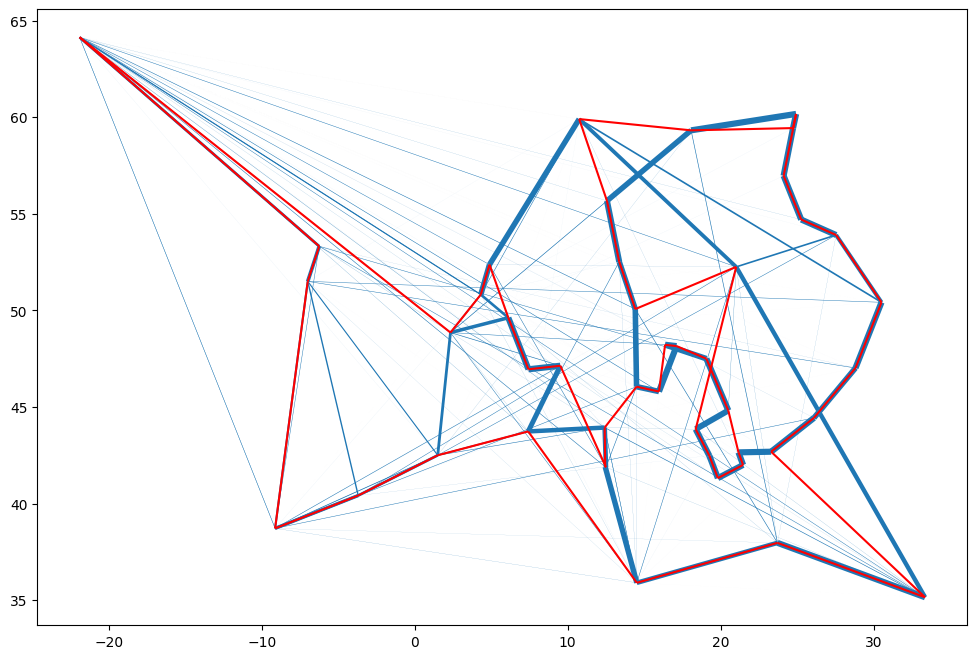

In [15]:
lines = []
colors = []
for i, v1 in enumerate(vertices):
    for j, v2 in enumerate(vertices):
        lines.append([(v1.x, v1.y), (v2.x, v2.y)])
        colors.append(pheromones[i][j])

lc = mc.LineCollection(lines, linewidths=np.array(colors))

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.add_collection(lc)
ax.autoscale()

solution = best_solution

# tady muzeme zkouset vliv jednotlivych parametru na vygenerovane reseni
# solution = list(generate_solutions(vertices, pheromones, distance, N=1, alpha=3, beta=1))[0]

print('Fitness: ', fitness(vertices, distance, solution))

solution_vertices = [vertices[i] for i in solution]
pprint.pprint(solution_vertices)

solution_lines = []
for i, j in zip(solution, solution[1:]):
    solution_lines.append([(vertices[i].x, vertices[i].y), (vertices[j].x, vertices[j].y)])
solution_lines.append([(vertices[solution[-1]].x, vertices[solution[-1]].y), (vertices[solution[0]].x, vertices[solution[0]].y)])
solutions_lc = mc.LineCollection(solution_lines, colors='red')
ax.add_collection(solutions_lc)

Pěkná simulace hledání nejkratší cesty v grafu se nachází [zde](http://thiagodnf.github.io/aco-simulator).

## Úkol na cvičení

Poslední zmiňovaný algoritmus, který zde ale není naimplementovaný, je optimalizace pomocí včelí kolonie. Umělé včelí kolonie (ABC) je optimalizační algoritmus založený na chování včel při hledání potravy. Včely jsou rozděleny do třech skupin - na dělnice, vyčkávající včely a průzkumníky. Každá dělnice opracovává jeden zdroj jídla (a pozice těchto zdrojů kódují řešení). Při opracování dělnice navštíví zdroje jídla v okolí, a pokud je jiné řešení kvalitnější (má lepší fitness) nahradí svůj zdroj tímto novým zdrojem. Potom se všechny dělnice sejdou v úle, vymění si informace o kvalitě zdrojů a vyčkávající včely si vyberou některé z těchto zdrojů pomocí ruletové selekce. Dělnice si zároveň pamatují, jak dlouho už opracovávají daný zdroj, a pokud přesáhne tato doba nastavený limit, zdroj opustí a stanou se z nich průzkumníci. Průzkumníci prohledávají prostor náhodně a hledají nové zdroje potravy

Zkuste si tedy naimplementovat ve zbytku cvičení optimalizaci pomocí včelí kolonie a vyřešit s ní třeba problém rastrigin funkce, který je výše vyřešený pomocí optimalizace hejna částic.

## Domácí úkol

Za domácí úkol budete mít vyřešit pomocí optimalizace mravenčí kolonií [Vehicle Routing Problem](https://en.wikipedia.org/wiki/Vehicle_routing_problem), což je vlastně jen zobecněný problém obchodního cestujícího na princip optimalizace rozvozu zásilek doručovací společnosti. Jedná se o to, že máme depa, každé má svá vlastní vozidla s danou kapacitou a nějakou množinu zásilek, které je potřeba rozvézt k jejich majitelům. Cílem je najít množinu doručovacích tras tak, aby byly všechny zásilky dodány majitelům a aby byly minimalizované celkové náklady, tedy aby byl použit co nejmenší počet vozidel a aby byly trasy co nejkratší.

V našem případě použijeme zjednodušenou verzi tohoto problému s jedním depem, které má neomezený počet vozidel jednoho typu. Vstupní data najdete ve složce *domaci_ukol_data*, jsou ve formátu xml a obsahují 3 soubory -- 2 malé a jeden větší, které zároveň obsahují:
- Seznam uzlů se souřadnicemi x a y, kdy uzel s typem 0 je depo, a ty ostatní s typem 1 jsou lokace zákazníků.
- Seznam vozidel, v tomto případě máme jeden typ vozidla, které musí začínat a končit v depu a má nějakou maximální kapacitu předmětů, které uveze.
- Seznam požadavků, neboli do jakého uzlu se toho má co dovézt.

Svůj kód, popis řešení, výsledky a jejich rozbor mi pošlete emailem do stanoveného deadline. Pro sepsání popisu algoritmu a výsledků použijte [tento template](https://github.com/kackamac/Prirodou-inspirovane-algoritmy/blob/master/11_rojove%20algoritmy/DU3_spojita_optimalizace.pdf).